# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
2362,2362,갈취 대화,헐 맛있겠다 떡볶이 먹자\n 그래.근데 저번에 5천원 언제 줄거야?\n 내가 삥 뜯...
2788,2788,직장 내 괴롭힘 대화,헐 오대리 옷 입은 거 봤어? 완전 구려.\n 아무도 안 말리나봐. 그러니까 직장 ...
1210,1210,직장 내 괴롭힘 대화,씨 이틀간 연차 좀 쓰지?\n네? 팀장님 무슨일로.\n집에 장례식이 좀 생겼는데 거...
1934,1934,기타 괴롭힘 대화,엄마 다녀왔습니다\n야이 미친년아 지금 몇시라고 기어들어오는거야\n야자 끝나고 버스...
9,9,협박 대화,야 쟤 잡아\n넵 알겠습니다.\n제발 손가락은 자르지 말아주세요\n야 미친 놈아 내...
1881,1881,갈취 대화,친구야 돈 있나 혹시?\n아니 없는데?\n에이 친한친구끼리 왜그래?\n너 저번에 빌...
3240,3240,일반 대화,"형제자매랑 사이 좋아?\n응, 정말 친해.\n가족여행 자주 가?\n응, 일년에 한 ..."
670,670,협박 대화,그 새끼 눈에 띄기만 하면 죽여버릴거니까 그런줄알아.\n아니 그래도 대화는 해봐야죠...
4030,4030,일반 대화,"가족은 잘 지내?\n응, 모두 건강해.\n형제자매랑 사이 좋아?\n응, 정말 친해...."
1031,1031,직장 내 괴롭힘 대화,강인턴 이제부터 회사 업무 외 모든 일은 나한테 보고하고 다녀오게.\n네.? 어떤 ...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## Augmentation

## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

Okt 토크나이저 활용

In [18]:
# Okt로 토큰화
tokenizer=Okt()
#tokenizer=Mecab()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

#### 단어사전 생성

In [21]:
# 'tokenized' 열의 모든 토큰을 모아 등장 빈도 계산
all_tokens = [token for tokens in train_data['tokenized'] for token in tokens]
counter = Counter(all_tokens)
# 가장 많이 등장하는 단어 vocab_size 개수만큼 남기기
counter = counter.most_common(VOCAB_SIZE)

In [22]:
# vocabulary 파일로 저장
word_to_index_path = './vocab.txt'

def save_word_index(counter):
    with open(word_to_index_path, 'w') as f:
        for idx, (word, _) in enumerate(counter):
            line = f"{word}: {idx}\n"
            f.write(line)
            
#save_word_index(counter)

In [23]:
# 단어 사전에 pad, unk 토큰 추가
special_tokens = ['<pad>', '<unk>']
# 인코딩, 디코딩에 활용할 단어사전 딕셔너리 생성
word_to_index = {token: idx for idx, token in enumerate(special_tokens)}
word_to_index.update({token: idx + len(special_tokens) for idx, (token, _) in enumerate(counter)})

In [24]:
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '<sos>': 5,
 '<eos>': 6,
 '!': 7,
 '내': 8,
 '해': 9,
 '뭐': 10,
 '는': 11,
 '도': 12,
 '좋아해': 13,
 '거': 14,
 '말': 15,
 '다': 16,
 '은': 17,
 '돈': 18,
 '친구': 19,
 '잘': 20,
 '니': 21,
 '있어': 22,
 '랑': 23,
 '요': 24,
 '영화': 25,
 '만': 26,
 '진짜': 27,
 '이야': 28,
 '정말': 29,
 '죄송합니다': 30,
 '한': 31,
 '게': 32,
 '지금': 33,
 '할': 34,
 '고': 35,
 '하고': 36,
 '한테': 37,
 '오늘': 38,
 '주로': 39,
 '님': 40,
 '주말': 41,
 '그냥': 42,
 '여행': 43,
 '돼': 44,
 '집': 45,
 '많이': 46,
 '자주': 47,
 '제발': 48,
 '가족': 49,
 '알': 50,
 '생각': 51,
 '거야': 52,
 '적': 53,
 '이랑': 54,
 '하는': 55,
 '더': 56,
 '운동': 57,
 '지': 58,
 '그렇게': 59,
 '너무': 60,
 '했어': 61,
 '빨리': 62,
 '회사': 63,
 '새끼': 64,
 '씨': 65,
 '만나': 66,
 '하면': 67,
 '아니야': 68,
 '없어': 69,
 '걸': 70,
 '수': 71,
 '애': 72,
 '면': 73,
 '줄': 74,
 '그런': 75,
 '이렇게': 76,
 '그게': 77,
 '그건': 78,
 '어제': 79,
 '서': 80,
 '이제': 81,
 '넌': 82,
 '대리': 83,
 '인데': 84,
 '사진': 85,
 '나도': 86,
 '엄마': 87,
 '아침': 88,
 '다녀': 89,
 '취미': 90,
 '부모님': 91,
 '만원': 92,
 '싶어'

#### 정수인코딩

In [25]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [26]:
train_data.sample(3)

,conversation,type,preprocessed,tokenized,encoded
1629,오 너가 새로 입사한 애냐 ? 네 반갑습네다 . 제가 이 회사에 새로 취직한 사...,2,오 너가 새로 입사한 애냐 ? 네 반갑습네다 . 제가 이 회사에 새로 취직한 사...,"[<sos>, 새로, 입사, 한, 애, 냐, ?, 반갑, 습, 다, ., 회사, 새...","[5, 860, 1196, 31, 72, 187, 3, 17015, 6092, 16..."
3779,우리 헤어지자 . 헤어지자고 ? 지금 장난해 ? 진심이야 . 나 너랑 헤어지...,0,우리 헤어지자 . 헤어지자고 ? 지금 장난해 ? 진심이야 . 나 너랑 헤어지...,"[<sos>, 헤어지자, ., 헤어지자, 고, ?, 지금, 장난, 해, ?, 진심,...","[5, 1018, 2, 1018, 35, 3, 33, 186, 9, 3, 1352,..."
2904,어제 길동 사원님이랑 둘이서 회사에서 배달 시켜 먹었다면서요 ? 아 네 같이 해야...,2,어제 길동 사원님이랑 둘이서 회사에서 배달 시켜 먹었다면서요 ? 아 네 같이 해야...,"[<sos>, 어제, 길동, 사원, 님, 이랑, 둘이서, 회사, 배달, 시켜, 먹었...","[5, 79, 358, 895, 40, 54, 7767, 63, 897, 1239,..."


## 전처리 후 분석

#### 토큰화된 데이터 길이 확인

최대 길이: 305
최소 길이: 13
평균 길이: 76.31515151515151
표준편차: 31.087848215261783


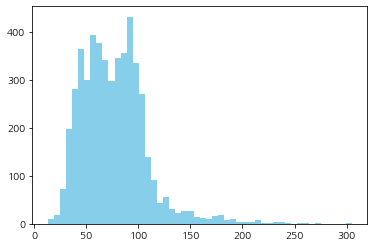

In [27]:
# 'encoded' 열의 각 리스트의 길이 계산
lengths = train_data['encoded'].apply(len)

print(f"최대 길이: {lengths.max()}")
print(f"최소 길이: {lengths.min()}")
print(f"평균 길이: {lengths.mean()}")
print(f"표준편차: {lengths.std()}")

# 길이 분포 시각화
plt.hist(lengths, bins=50, color='skyblue')
plt.show()

#### 패딩 적용

In [28]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [29]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [30]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


In [45]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_test)
counter.most_common()

[(4, 116), (3, 115), (0, 95), (1, 89), (2, 80)]

# 모델링

In [31]:
!pip install wandb==0.16.0

     |████████████████████████████████| 2.1 MB 5.0 MB/s            
     |████████████████████████████████| 296 kB 71.0 MB/s            
     |████████████████████████████████| 207 kB 78.0 MB/s            
     |████████████████████████████████| 62 kB 2.3 MB/s             
     |████████████████████████████████| 143 kB 76.9 MB/s            
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7


In [32]:
import wandb

wandb.login(key = '809618c39f10bc0019fd6fd710cb28c698c30197')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [33]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        "batch_size": {
            "values": [16, 32, 64]
            },
        "optimizer": {
            "values": ["adam", "rmsprop"]
            },
        "dropout_rate":{
            "values": [0.1, 0.2, 0.3]
            }
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 128,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [34]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [35]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [36]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import wandb

# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화'
    ]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# 5x5의 표의 [i,j]의 위치는 실제값은 i번째 클래스이고, 예측값은 j번째 클래스임을 나타냄
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_epoch_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        if epoch == self.params['epochs'] - 1:  
            pred_test = self.model.predict(self.X_test).argmax(axis=1)
            self.y_test = np.array(self.y_test)
            pred_test = np.array(pred_test)
            
            # 5개의 클래스에서 두 개씩 뽑아내어 비교
            # 실제값이 class_a일 때, 예측값을 claas_b로 예측한 횟수
            for class_a in range(self.class_num):
                for class_b in range(self.class_num):
                    num = len(np.where((self.y_test == class_a) & (pred_test == class_b))[0])
                    self.table[class_a, class_b] += num

            # 표 그리기
            cm_plot = plot_table(self.table)
            
            # wandb에 로그로 저장
            cm_image = wandb.Image(cm_plot)
            wandb.log({"Overall Prediction Result": cm_image})


In [41]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_1DCNN_GRU(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # confunsion matrix 그리는 콜백
    cm_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    
    # 학습
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cm_callback])
    
    # test dataset으로 accuracy 계산    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    # test dataset으로 f1 score 계산
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

Create sweep with ID: a4zowdk2
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_1DCNN_GRU/sweeps/a4zowdk2


wandb: Agent Starting Run: ty6qnk7k with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 9
wandb: 	learning_rate: 0.07429243229686622
wandb: 	optimizer: adam


Epoch 1/9
124/124 [==============================] - 18s 128ms/step - loss: 1.5507 - accuracy: 0.2386 - val_loss: 1.0807 - val_accuracy: 0.4828
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 16s 127ms/step - loss: 1.0445 - accuracy: 0.4924 - val_loss: 0.9598 - val_accuracy: 0.5192
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 16s 125ms/step - loss: 0.7062 - accuracy: 0.6821 - val_loss: 0.7622 - val_accuracy: 0.6747
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best)... Done. 0.1s


Epoch 4/9
124/124 [==============================] - 16s 126ms/step - loss: 0.4518 - accuracy: 0.8149 - val_loss: 0.7463 - val_accuracy: 0.7394
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005443-ty6qnk7k/files/model-best)... Done. 0.1s


Epoch 5/9
124/124 [==============================] - 16s 126ms/step - loss: 0.3035 - accuracy: 0.8818 - val_loss: 0.8394 - val_accuracy: 0.7091
Epoch 6/9
124/124 [==============================] - 15s 124ms/step - loss: 0.2146 - accuracy: 0.9215 - val_loss: 0.9921 - val_accuracy: 0.7091
Epoch 7/9
124/124 [==============================] - 15s 123ms/step - loss: 0.1408 - accuracy: 0.9525 - val_loss: 1.0490 - val_accuracy: 0.7313
Epoch 8/9
124/124 [==============================] - 15s 124ms/step - loss: 0.0853 - accuracy: 0.9730 - val_loss: 1.2384 - val_accuracy: 0.7374
Epoch 9/9
124/124 [==============================] - 16s 125ms/step - loss: 0.0711 - accuracy: 0.9780 - val_loss: 1.3894 - val_accuracy: 0.7152
16/16 - 0s - loss: 1.2693 - accuracy: 0.7515


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▄▃▂▂▁▁▁
val_accuracy,▁▂▆█▇▇██▇
val_loss,▅▃▁▁▂▄▄▆█
Test Accuracy Rate,0.75152
Test Error Rate,0.24848
Test F1 Score,0.75152


wandb: Agent Starting Run: fp9i01qz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epoch: 5
wandb: 	learning_rate: 0.03201931369556106
wandb: 	optimizer: adam


Epoch 1/5
248/248 [==============================] - 33s 126ms/step - loss: 1.4470 - accuracy: 0.2828 - val_loss: 1.1016 - val_accuracy: 0.4040
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best)... Done. 0.2s


Epoch 2/5
248/248 [==============================] - 31s 124ms/step - loss: 1.1162 - accuracy: 0.4078 - val_loss: 1.0599 - val_accuracy: 0.5111
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best)... Done. 0.2s


Epoch 3/5
248/248 [==============================] - 31s 124ms/step - loss: 0.8275 - accuracy: 0.6008 - val_loss: 0.6668 - val_accuracy: 0.6303
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best)... Done. 0.1s


Epoch 4/5
248/248 [==============================] - 31s 124ms/step - loss: 0.4393 - accuracy: 0.7896 - val_loss: 0.5398 - val_accuracy: 0.8040
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_005742-fp9i01qz/files/model-best)... Done. 0.1s


Epoch 5/5
248/248 [==============================] - 31s 125ms/step - loss: 0.1758 - accuracy: 0.9391 - val_loss: 0.6535 - val_accuracy: 0.7879
16/16 - 0s - loss: 0.6882 - accuracy: 0.7980


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▂▄▆█
epoch,▁▃▅▆█
loss,█▆▅▂▁
val_accuracy,▁▃▅██
val_loss,█▇▃▁▂
Test Accuracy Rate,0.79798
Test Error Rate,0.20202
Test F1 Score,0.79798


wandb: Agent Starting Run: u2vhtki1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0045966401146566695
wandb: 	optimizer: rmsprop


Epoch 1/9
248/248 [==============================] - 34s 128ms/step - loss: 1.3554 - accuracy: 0.3053 - val_loss: 1.0874 - val_accuracy: 0.4848
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best)... Done. 0.2s


Epoch 2/9
248/248 [==============================] - 31s 124ms/step - loss: 1.0567 - accuracy: 0.4962 - val_loss: 0.9447 - val_accuracy: 0.5636
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best)... Done. 0.1s


Epoch 3/9
248/248 [==============================] - 31s 123ms/step - loss: 0.7074 - accuracy: 0.7106 - val_loss: 0.6889 - val_accuracy: 0.7212
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010049-u2vhtki1/files/model-best)... Done. 0.1s


Epoch 4/9
248/248 [==============================] - 31s 125ms/step - loss: 0.4385 - accuracy: 0.8402 - val_loss: 0.7562 - val_accuracy: 0.7192
Epoch 5/9
248/248 [==============================] - 31s 124ms/step - loss: 0.2722 - accuracy: 0.9053 - val_loss: 0.8363 - val_accuracy: 0.7475
Epoch 6/9
248/248 [==============================] - 31s 125ms/step - loss: 0.1676 - accuracy: 0.9467 - val_loss: 0.8534 - val_accuracy: 0.7354
Epoch 7/9
248/248 [==============================] - 31s 125ms/step - loss: 0.1160 - accuracy: 0.9593 - val_loss: 0.9697 - val_accuracy: 0.7556
Epoch 8/9
248/248 [==============================] - 31s 124ms/step - loss: 0.0753 - accuracy: 0.9750 - val_loss: 0.8025 - val_accuracy: 0.7838
Epoch 9/9
248/248 [==============================] - 31s 125ms/step - loss: 0.0428 - accuracy: 0.9881 - val_loss: 0.9952 - val_accuracy: 0.7859
16/16 - 0s - loss: 0.9671 - accuracy: 0.7980


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▅▃▂▂▁▁▁
val_accuracy,▁▃▆▆▇▇▇██
val_loss,█▅▁▂▄▄▆▃▆
Test Accuracy Rate,0.79798
Test Error Rate,0.20202
Test F1 Score,0.79798


wandb: Agent Starting Run: 1mvz9plp with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 6
wandb: 	learning_rate: 0.08840274711412029
wandb: 	optimizer: rmsprop


Epoch 1/6
124/124 [==============================] - 19s 132ms/step - loss: 1.5036 - accuracy: 0.2586 - val_loss: 1.0850 - val_accuracy: 0.4828
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best)... Done. 0.1s


Epoch 2/6
124/124 [==============================] - 16s 128ms/step - loss: 1.1118 - accuracy: 0.4641 - val_loss: 0.9737 - val_accuracy: 0.5051
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best)... Done. 0.1s


Epoch 3/6
124/124 [==============================] - 16s 126ms/step - loss: 0.9341 - accuracy: 0.5593 - val_loss: 0.9330 - val_accuracy: 0.5697
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best)... Done. 0.1s


Epoch 4/6
124/124 [==============================] - 16s 126ms/step - loss: 0.7550 - accuracy: 0.6467 - val_loss: 0.7911 - val_accuracy: 0.6424
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best)... Done. 0.1s


Epoch 5/6
124/124 [==============================] - 16s 126ms/step - loss: 0.6282 - accuracy: 0.7051 - val_loss: 0.7651 - val_accuracy: 0.6848
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010559-1mvz9plp/files/model-best)... Done. 0.1s


Epoch 6/6
124/124 [==============================] - 16s 126ms/step - loss: 0.5075 - accuracy: 0.7831 - val_loss: 0.9693 - val_accuracy: 0.6424
16/16 - 0s - loss: 0.9560 - accuracy: 0.6222


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▅▆▇█
epoch,▁▂▄▅▇█
loss,█▅▄▃▂▁
val_accuracy,▁▂▄▇█▇
val_loss,█▆▅▂▁▅
Test Accuracy Rate,0.62222
Test Error Rate,0.37778
Test F1 Score,0.62222


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vrtv4pul with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 8
wandb: 	learning_rate: 0.07033150222377574
wandb: 	optimizer: rmsprop


Epoch 1/8
248/248 [==============================] - 34s 129ms/step - loss: 1.4148 - accuracy: 0.2967 - val_loss: 1.1786 - val_accuracy: 0.4000
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 31s 125ms/step - loss: 1.0604 - accuracy: 0.4745 - val_loss: 0.9343 - val_accuracy: 0.5778
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 31s 125ms/step - loss: 0.8030 - accuracy: 0.6351 - val_loss: 0.9071 - val_accuracy: 0.6384
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best)... Done. 0.1s


Epoch 4/8
248/248 [==============================] - 31s 125ms/step - loss: 0.5789 - accuracy: 0.7561 - val_loss: 0.7898 - val_accuracy: 0.7030
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best)... Done. 0.1s


Epoch 5/8
248/248 [==============================] - 31s 126ms/step - loss: 0.3777 - accuracy: 0.8621 - val_loss: 0.8383 - val_accuracy: 0.7010
Epoch 6/8
248/248 [==============================] - 31s 125ms/step - loss: 0.2495 - accuracy: 0.9139 - val_loss: 0.7753 - val_accuracy: 0.7354
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_010815-vrtv4pul/files/model-best)... Done. 0.1s


Epoch 7/8
248/248 [==============================] - 31s 126ms/step - loss: 0.1638 - accuracy: 0.9508 - val_loss: 0.9446 - val_accuracy: 0.7253
Epoch 8/8
248/248 [==============================] - 31s 125ms/step - loss: 0.1173 - accuracy: 0.9654 - val_loss: 0.8555 - val_accuracy: 0.7616
16/16 - 0s - loss: 0.7577 - accuracy: 0.8242


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▃▂▂▁▁
val_accuracy,▁▄▆▇▇▇▇█
val_loss,█▄▃▁▂▁▄▂
Test Accuracy Rate,0.82424
Test Error Rate,0.17576
Test F1 Score,0.82424


wandb: Agent Starting Run: czc2tsfz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0443293217893753
wandb: 	optimizer: adam


Epoch 1/9
62/62 [==============================] - 11s 140ms/step - loss: 1.6078 - accuracy: 0.2093 - val_loss: 1.5982 - val_accuracy: 0.1657
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best)... Done. 0.1s


Epoch 2/9
62/62 [==============================] - 8s 130ms/step - loss: 1.3542 - accuracy: 0.3333 - val_loss: 1.0621 - val_accuracy: 0.5030
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best)... Done. 0.1s


Epoch 3/9
62/62 [==============================] - 8s 128ms/step - loss: 1.0147 - accuracy: 0.5172 - val_loss: 0.8846 - val_accuracy: 0.5980
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011305-czc2tsfz/files/model-best)... Done. 0.1s


Epoch 4/9
62/62 [==============================] - 8s 127ms/step - loss: 0.7379 - accuracy: 0.6798 - val_loss: 0.9853 - val_accuracy: 0.5576
Epoch 5/9
62/62 [==============================] - 8s 127ms/step - loss: 0.5251 - accuracy: 0.7793 - val_loss: 1.0793 - val_accuracy: 0.6081
Epoch 6/9
62/62 [==============================] - 8s 127ms/step - loss: 0.3813 - accuracy: 0.8540 - val_loss: 1.1139 - val_accuracy: 0.6606
Epoch 7/9
62/62 [==============================] - 8s 127ms/step - loss: 0.2756 - accuracy: 0.8982 - val_loss: 1.2621 - val_accuracy: 0.6364
Epoch 8/9
62/62 [==============================] - 8s 125ms/step - loss: 0.2134 - accuracy: 0.9227 - val_loss: 1.3796 - val_accuracy: 0.6626
Epoch 9/9
62/62 [==============================] - 8s 128ms/step - loss: 0.1584 - accuracy: 0.9457 - val_loss: 1.6170 - val_accuracy: 0.6263
16/16 - 0s - loss: 1.5877 - accuracy: 0.6424


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▂▄▅▆▇███
epoch,▁▂▃▄▅▅▆▇█
loss,█▇▅▄▃▂▂▁▁
val_accuracy,▁▆▇▇▇███▇
val_loss,█▃▁▂▃▃▅▆█
Test Accuracy Rate,0.64242
Test Error Rate,0.35758
Test F1 Score,0.64242


wandb: Agent Starting Run: nsvi4go9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 10
wandb: 	learning_rate: 0.08621168236142937
wandb: 	optimizer: adam


Epoch 1/10
62/62 [==============================] - 11s 141ms/step - loss: 1.6071 - accuracy: 0.2088 - val_loss: 1.6047 - val_accuracy: 0.1677
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best)... Done. 0.1s


Epoch 2/10
62/62 [==============================] - 8s 128ms/step - loss: 1.3884 - accuracy: 0.3301 - val_loss: 1.0751 - val_accuracy: 0.4444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best)... Done. 0.1s


Epoch 3/10
62/62 [==============================] - 8s 128ms/step - loss: 0.9878 - accuracy: 0.5242 - val_loss: 0.7874 - val_accuracy: 0.5879
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011446-nsvi4go9/files/model-best)... Done. 0.1s


Epoch 4/10
62/62 [==============================] - 8s 130ms/step - loss: 0.7000 - accuracy: 0.6760 - val_loss: 0.8099 - val_accuracy: 0.6505
Epoch 5/10
62/62 [==============================] - 8s 126ms/step - loss: 0.4805 - accuracy: 0.7934 - val_loss: 0.7956 - val_accuracy: 0.6929
Epoch 6/10
62/62 [==============================] - 8s 125ms/step - loss: 0.3362 - accuracy: 0.8684 - val_loss: 0.8669 - val_accuracy: 0.7192
Epoch 7/10
62/62 [==============================] - 8s 128ms/step - loss: 0.2246 - accuracy: 0.9179 - val_loss: 0.9943 - val_accuracy: 0.7131
Epoch 8/10
62/62 [==============================] - 8s 127ms/step - loss: 0.1439 - accuracy: 0.9505 - val_loss: 1.2586 - val_accuracy: 0.6747
Epoch 9/10
62/62 [==============================] - 8s 126ms/step - loss: 0.1157 - accuracy: 0.9606 - val_loss: 1.3347 - val_accuracy: 0.6929
Epoch 10/10
62/62 [==============================] - 8s 128ms/step - loss: 0.0802 - accuracy: 0.9747 - val_loss: 1.2816 - val_accuracy: 0.7293
16/16

Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▂▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▃▂▂▁▁▁
val_accuracy,▁▄▆▇███▇██
val_loss,█▃▁▁▁▂▃▅▆▅
Test Accuracy Rate,0.74141
Test Error Rate,0.25859
Test F1 Score,0.74141


wandb: Agent Starting Run: 8cd7pbmo with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 9
wandb: 	learning_rate: 0.07977952012622797
wandb: 	optimizer: adam


Epoch 1/9
248/248 [==============================] - 34s 126ms/step - loss: 1.4665 - accuracy: 0.2894 - val_loss: 1.0613 - val_accuracy: 0.4606
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best)... Done. 0.1s


Epoch 2/9
248/248 [==============================] - 31s 126ms/step - loss: 0.8799 - accuracy: 0.5919 - val_loss: 0.6807 - val_accuracy: 0.7152
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best)... Done. 0.1s


Epoch 3/9
248/248 [==============================] - 31s 126ms/step - loss: 0.6018 - accuracy: 0.7308 - val_loss: 0.6590 - val_accuracy: 0.7232
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best)... Done. 0.1s


Epoch 4/9
248/248 [==============================] - 32s 127ms/step - loss: 0.3861 - accuracy: 0.8444 - val_loss: 0.6324 - val_accuracy: 0.7414
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_011632-8cd7pbmo/files/model-best)... Done. 0.1s


Epoch 5/9
248/248 [==============================] - 31s 126ms/step - loss: 0.2417 - accuracy: 0.9043 - val_loss: 0.8124 - val_accuracy: 0.7434
Epoch 6/9
248/248 [==============================] - 31s 127ms/step - loss: 0.1970 - accuracy: 0.9308 - val_loss: 0.8778 - val_accuracy: 0.7576
Epoch 7/9
248/248 [==============================] - 31s 126ms/step - loss: 0.1418 - accuracy: 0.9490 - val_loss: 0.9593 - val_accuracy: 0.7434
Epoch 8/9
248/248 [==============================] - 31s 126ms/step - loss: 0.0867 - accuracy: 0.9712 - val_loss: 1.2507 - val_accuracy: 0.7232
Epoch 9/9
248/248 [==============================] - 31s 125ms/step - loss: 0.0599 - accuracy: 0.9798 - val_loss: 1.1233 - val_accuracy: 0.7737
16/16 - 0s - loss: 1.1899 - accuracy: 0.7636


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▅▇▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▅▄▃▂▂▁▁▁
val_accuracy,▁▇▇▇▇█▇▇█
val_loss,▆▂▁▁▃▄▅█▇
Test Accuracy Rate,0.76364
Test Error Rate,0.23636
Test F1 Score,0.76364


wandb: Agent Starting Run: ncn5nx7r with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 8
wandb: 	learning_rate: 0.017293246292798662
wandb: 	optimizer: adam


Epoch 1/8
248/248 [==============================] - 35s 130ms/step - loss: 1.4125 - accuracy: 0.2960 - val_loss: 1.0858 - val_accuracy: 0.4687
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012147-ncn5nx7r/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012147-ncn5nx7r/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 31s 127ms/step - loss: 1.0734 - accuracy: 0.4783 - val_loss: 0.8717 - val_accuracy: 0.6000
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012147-ncn5nx7r/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012147-ncn5nx7r/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 31s 127ms/step - loss: 0.7879 - accuracy: 0.6432 - val_loss: 1.0743 - val_accuracy: 0.6020
Epoch 4/8
248/248 [==============================] - 32s 127ms/step - loss: 0.5560 - accuracy: 0.7470 - val_loss: 0.9992 - val_accuracy: 0.6343
Epoch 5/8
248/248 [==============================] - 31s 126ms/step - loss: 0.4038 - accuracy: 0.8341 - val_loss: 1.0353 - val_accuracy: 0.6727
Epoch 6/8
248/248 [==============================] - 31s 125ms/step - loss: 0.2686 - accuracy: 0.8949 - val_loss: 1.2778 - val_accuracy: 0.6828
Epoch 7/8
248/248 [==============================] - 31s 125ms/step - loss: 0.1886 - accuracy: 0.9306 - val_loss: 1.5559 - val_accuracy: 0.6364
Epoch 8/8
248/248 [==============================] - 31s 126ms/step - loss: 0.1213 - accuracy: 0.9545 - val_loss: 1.7834 - val_accuracy: 0.6525
16/16 - 0s - loss: 1.5943 - accuracy: 0.6869


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇▇██
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▃▃▂▁▁
val_accuracy,▁▅▅▆██▆▇
val_loss,▃▁▃▂▂▄▆█
Test Accuracy Rate,0.68687
Test Error Rate,0.31313
Test F1 Score,0.68687


wandb: Agent Starting Run: k1m1qxjo with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epoch: 5
wandb: 	learning_rate: 0.05472552411189702
wandb: 	optimizer: rmsprop


Epoch 1/5
248/248 [==============================] - 34s 126ms/step - loss: 1.3345 - accuracy: 0.3283 - val_loss: 1.1833 - val_accuracy: 0.4343
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best)... Done. 0.1s


Epoch 2/5
248/248 [==============================] - 31s 125ms/step - loss: 0.8707 - accuracy: 0.6104 - val_loss: 0.6313 - val_accuracy: 0.7616
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best)... Done. 0.1s


Epoch 3/5
248/248 [==============================] - 31s 125ms/step - loss: 0.4418 - accuracy: 0.8412 - val_loss: 0.4477 - val_accuracy: 0.8424
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best)... Done. 0.1s


Epoch 4/5
248/248 [==============================] - 31s 126ms/step - loss: 0.1965 - accuracy: 0.9371 - val_loss: 0.3829 - val_accuracy: 0.8626
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_012621-k1m1qxjo/files/model-best)... Done. 0.1s


Epoch 5/5
248/248 [==============================] - 31s 127ms/step - loss: 0.1032 - accuracy: 0.9707 - val_loss: 0.3988 - val_accuracy: 0.8747
16/16 - 0s - loss: 0.3745 - accuracy: 0.9051


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
Test Accuracy Rate,0.90505
Test Error Rate,0.09495
Test F1 Score,0.90505


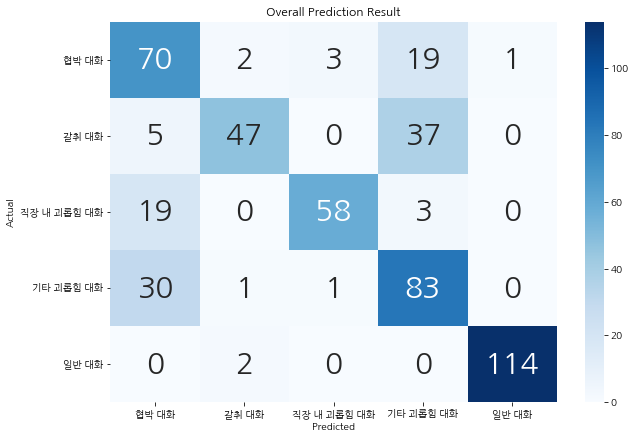

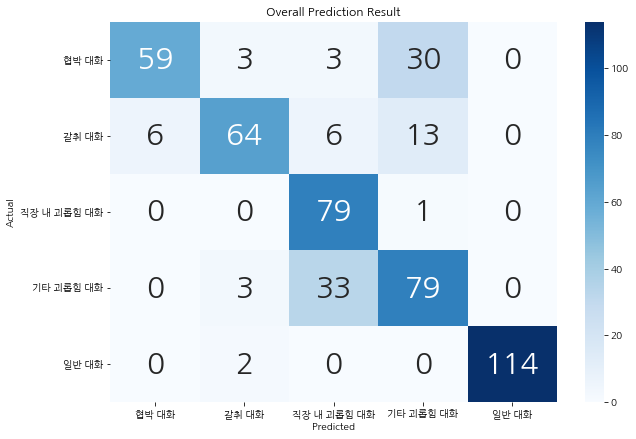

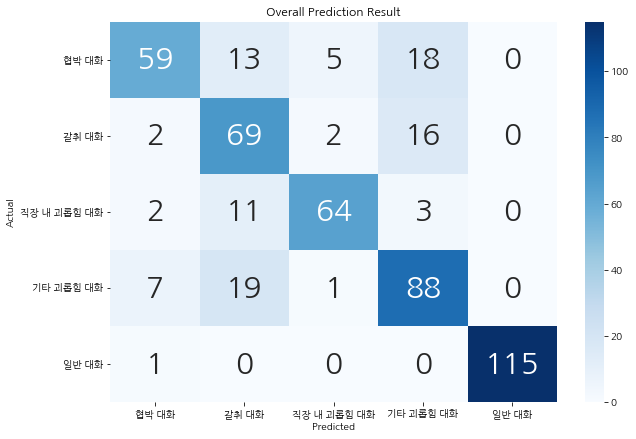

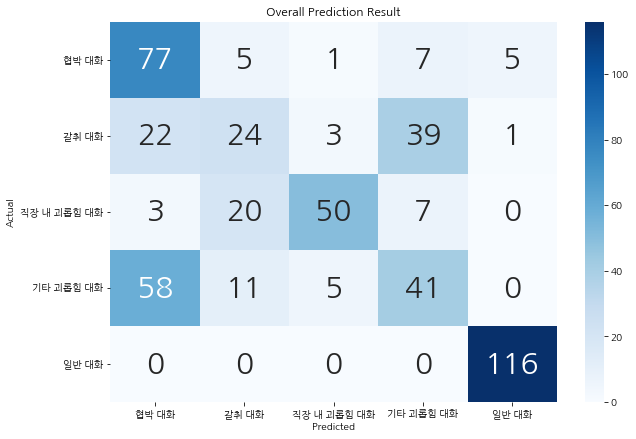

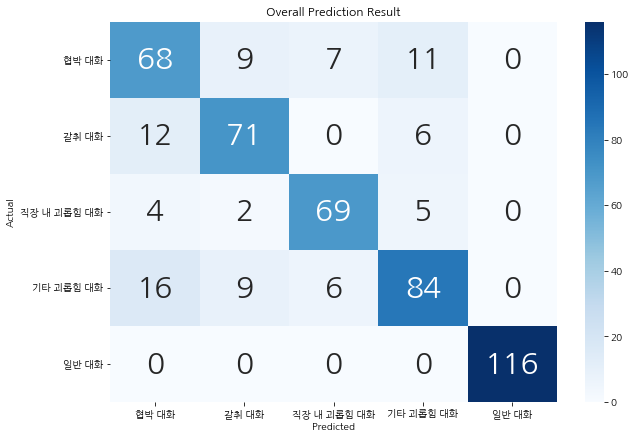

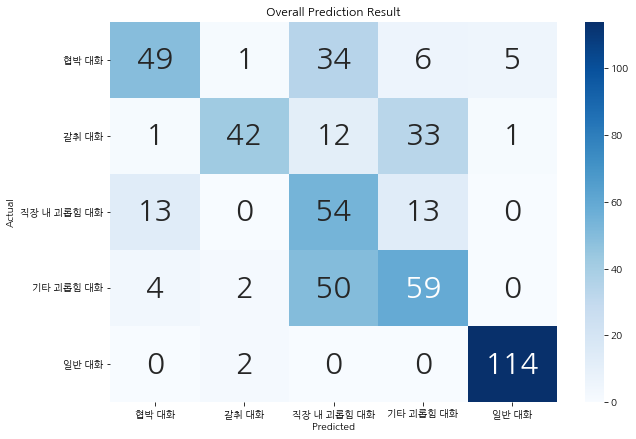

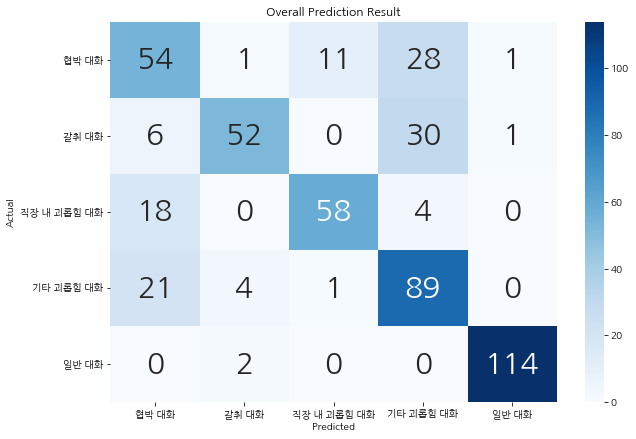

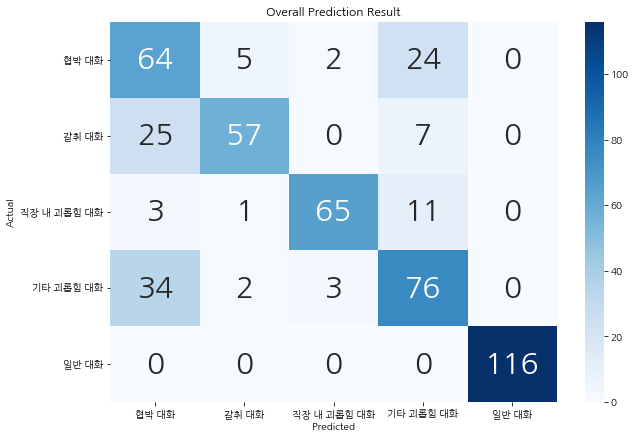

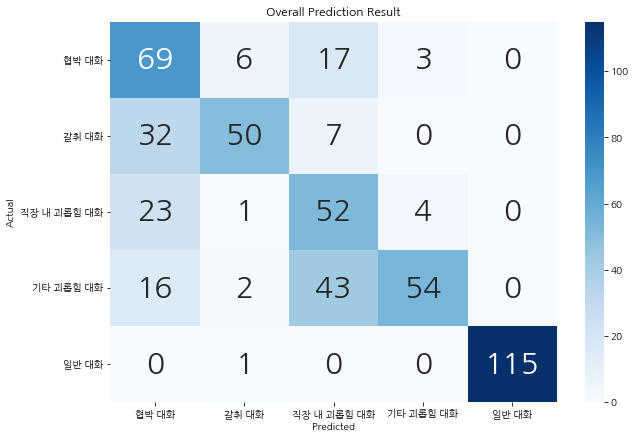

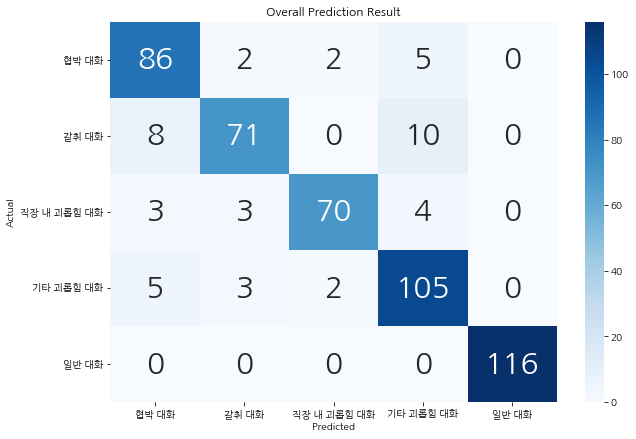

In [42]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_1DCNN_GRU')


wandb.agent(sweep_id,
            function=sweep_train,
            count=10)